# Student Classification Project
*By Isa de Luis*

## Introduction

For this project, we will be looking at data from different students and try and classify their grade based on following factors:
* Student Age
* Sex
* High School Type
* Scholarship
* Additional Work (do they work a job outside of school)
* Sports Activity (do they play a sport outside of school)
* Transportation (how do they get to school)
* Weekly Hours Spent Studying
* Attendence (how often do they attend class)
* Reading (do they read outside of class)
* Notes (do they take notes during class)
* Listening in class (do they listen during class)
* Project Work (do they work on group projects)

For this algorithm to responsibly create value, it would need to achieve an accuracy level that significantly surpasses random chance and provides reliable predications, ideally above 70 or 80% to ensure meaningful predictions. Accurately predicted student grades has implications for academic advising, resource allocation, and personalized learning strategies. Given the sensitive nature of educational outcomes, even modest inaccuracies can have significant consequences such as misinforming interventions or support strategies for students.

The stakeholders in this algorithm include teachers and academic institutions.  Teachers could use the algorithm predictions to identify students in need of support and customize their learning paths, and academic institutions could use the predictions for optimizing academic programs and resource allocation. However, there are significant risk with this algorithm. Incorrect predictions could lead to the misclassification of student performance, potentially causing unwarranted stress for students predicted to underperform or false reassurance for those predicted to excel. Over-reliance on the model without human intervention could further amplify these risks. Bias is another critical risk, if the training data is biased towards certain demographic groups, it could reinforce educational inequalities. TO mitigate these risks, human decision-makers should always have the final say in a grade and the model should be regularly audited and the data examined to ensure that it is not biased.

## Imports

In order for the analysis to be successful, we need to download the [following data](https://drive.google.com/file/d/1n6tgoRHzAULLapXfEDRofT3c1E6hyPTv/view?usp=sharing). To make it simple, I put the data into google drive, and you can download the data from there. Once the data is downloaded, you ened move it into the same directory as this notebook. Additionally, you need to import the following packages by running the code block below:
* `pandas`: `pandas` is used to clean the data
* `torch`: `torch` (and its modules) are used to create our neural network
* `sklearn`: `sklearn` is used to split our data into testing data and training data
* `numpy`: `numpy`is used to create the objects used in the neural network
* `matplotlib.pyplot`: `matplotlib` is used to create plots of the loss and accuracy of our model once the neural network has run.

I'm also going to set the random seed to be 42 so that the results are the same each time I run the model with the same test/train data. If I resplit the data, the model will have different results.

In [63]:
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import random 
%matplotlib inline

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Now, you need to the import the data you downloaded into the notebook. To do this, we use a Pandas function, `read_csv` that reads the data in the csv file and imports it into a Pandas Dataframe. Once we import the data, we print the first few lines to make sure the importation occurred correctly.

In [64]:
data_df = pd.read_csv("student.csv")
data_df.head()

,Unnamed: 0,Id,Student_Age,Sex,High_School_Type,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade
0,0,5001,21,Male,Other,50%,Yes,No,Private,0,Always,Yes,Yes,No,No,AA
1,1,5002,20,Male,Other,50%,Yes,No,Private,0,Always,Yes,No,Yes,Yes,AA
2,2,5003,21,Male,State,50%,No,No,Private,2,Never,No,No,No,Yes,AA
3,3,5004,18,Female,Private,50%,Yes,No,Bus,2,Always,No,Yes,No,No,AA
4,4,5005,22,Male,Private,50%,No,No,Bus,12,Always,Yes,No,Yes,Yes,AA


## Cleaning the Data
Now that we have the data import, we need to clean and transform the data so that we can use it in our classification neural network. The first thing we're going to do is drop the "unnamed" and "id" columns since they are not necessary for our analysis.

In [65]:
data_df = data_df.drop(["Unnamed: 0", "Id"], axis = 1)
data_df.head()

,Student_Age,Sex,High_School_Type,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade
0,21,Male,Other,50%,Yes,No,Private,0,Always,Yes,Yes,No,No,AA
1,20,Male,Other,50%,Yes,No,Private,0,Always,Yes,No,Yes,Yes,AA
2,21,Male,State,50%,No,No,Private,2,Never,No,No,No,Yes,AA
3,18,Female,Private,50%,Yes,No,Bus,2,Always,No,Yes,No,No,AA
4,22,Male,Private,50%,No,No,Bus,12,Always,Yes,No,Yes,Yes,AA


Now, we need to turn the text data into numerical equivalents.
### Sex
The first column we're going to transform is "sex". There are two responses for "sex", "Male" or "Female". For our analysis, we're going make "Male" equivalent to 0 and "Female" equivalent to 1. Once we've done the transformation, we will print the number of 0s and 1s in the "Sex" column to ensure the transformation was successful.

In [66]:
data_df.replace({'Sex':{'Male': 0, 
                        'Female':1}}, inplace=True) # use replace method to rename values
data_df[["Sex"]].value_counts() # print the number people of each sex

Sex
0      87
1      58
Name: count, dtype: int64

### High School Type
Now, we're going to transform the "high school type" column. There are 3 types of high schools, state, private, or other. The following encodings will be used for the high schools:
* State: 0
* Private: 1
* Other: 2

In [67]:
data_df.replace({'High_School_Type':{"State": 0,
                                     "Private": 1,
                                     "Other": 2}}, inplace =True)
data_df[["High_School_Type"]].value_counts()

High_School_Type
0                   103
1                    25
2                    17
Name: count, dtype: int64

### Scholarship
For the scholarship category, we can keep the numerical values, but we need to drop the `%` from each item. 

In [68]:
data_df.replace({"Scholarship":{"50%": 50,
                                "75%": 75,
                                "100%": 100,
                                "25%": 25,
                                "0%": 0}}, inplace = True)
data_df[["Scholarship"]].value_counts()

Scholarship
50             76
75             42
100            23
25              3
0               1
Name: count, dtype: int64

### Additional Work
For the additional work category, we will encode "No" as 0 and "Yes" as 1.

In [69]:
data_df.replace({"Additional_Work": {"No": 0,
                                     "Yes": 1}}, inplace = True)
data_df[["Additional_Work"]].value_counts()

Additional_Work
0                  96
1                  49
Name: count, dtype: int64

### Sports Activity
Like the additional work category, we will encode "No" as 0 and "Yes" as 1.

In [70]:
data_df.replace({"Sports_activity": {"No": 0,
                                     "Yes": 1}}, inplace = True)
data_df["Sports_activity"].value_counts()

Sports_activity
0    87
1    58
Name: count, dtype: int64

### Transportation
For the transportation column, we will turn the "Private" values to 0 and the "Bus" values to 1.

In [71]:
data_df.replace({"Transportation": {"Private": 0,
                                     "Bus": 1}}, inplace = True)
data_df["Transportation"].value_counts()

Transportation
0    84
1    61
Name: count, dtype: int64

### Attendance
For attendance, a student can either always be present, sometimes be present, or never be present. We will use the following encodings for these values:
* Always: 0
* Sometimes: 1
* Never: 2

In [72]:
data_df.replace({"Attendance": {"Always": 0,
                                 "Sometimes": 1,
                                 "Never": 2}}, inplace = True)


You'll notice that there is an additional encoding that we did not create, `3`. For this project, we are just going to delete that row of data since we did not create the encoding and do not know what it means.

In [73]:
data_df = data_df[data_df['Attendance'] != '3'] # essentially, drops any row where attendance == 3
data_df["Attendance"].value_counts() # sanity check to make sure it worked

Attendance
0    98
1    25
2    21
Name: count, dtype: int64

# Reading, Notes, Listening in Class, and Project Work
For these categories, we will encode "No" as 0 and "Yes" as 1.

In [74]:
data_df.replace({"Reading": {"No": 0,
                             "Yes": 1}}, inplace = True)
data_df.replace({"Notes": {"No": 0,
                           "Yes": 1}}, inplace = True)
data_df.replace({"Listening_in_Class": {"No": 0,
                                        "Yes": 1}}, inplace = True)
data_df.replace({"Project_work": {"No": 0,
                                  "Yes": 1}}, inplace = True)
data_df["Reading"].value_counts()

Reading
0    75
1    69
Name: count, dtype: int64

In [75]:
data_df["Notes"].value_counts()

Notes
1    76
0    66
6     2
Name: count, dtype: int64

In [76]:
data_df["Listening_in_Class"].value_counts()

Listening_in_Class
1    74
0    69
6     1
Name: count, dtype: int64

You'll notice for "Notes" and "Listening in Class", we have the same issue as with "Attendance", where we have an encoding we did not create. Once again, we'll just drop any row with that encoding.

In [77]:
data_df = data_df[data_df['Notes'] != '6'] # essentially, drops any row where Notes == 6
data_df["Notes"].value_counts() # sanity check to make sure it worked

Notes
1    76
0    66
Name: count, dtype: int64

In [78]:
data_df = data_df[data_df['Listening_in_Class'] != '6'] # essentially, drops any row where Listening_in_Class == 6
data_df["Listening_in_Class"].value_counts() # sanity check to make sure it worked

Listening_in_Class
1    73
0    68
Name: count, dtype: int64

In [79]:
data_df["Project_work"].value_counts()

Project_work
0    72
1    69
Name: count, dtype: int64

### Grades
The final thing you need to encode is grades. There are 8 possible grades that a student can achieve and we will use the following encodings for each grade:
* AA: 0
* BA: 1
* BB: 2
* CC: 3
* DD: 4
* DC: 5
* CB: 6
* Fail: 7 

In [80]:
data_df.replace({"Grade": {"AA": 0,
                           "BA": 1,
                           "BB": 2,
                           "CC": 3,
                           "DD": 4,
                           "DC": 5,
                           "CB": 6,
                           "Fail": 7}}, inplace = True)
data_df["Grade"].value_counts()

Grade
0    35
1    22
2    20
3    17
4    16
5    13
6    10
7     8
Name: count, dtype: int64

In [81]:
data_df.to_csv("cleaned_stu_data.csv")

Before we move on to the next step, let's check that everything has been encoded properly. When we print the dataframe, we should only see numbers in each row, excluding the column headers.

In [82]:
data_df.head()

,Student_Age,Sex,High_School_Type,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade
0,21,0,2,50,1,0,0,0,0,1,1,0,0,0
1,20,0,2,50,1,0,0,0,0,1,0,1,1,0
2,21,0,0,50,0,0,0,2,2,0,0,0,1,0
3,18,1,1,50,1,0,1,2,0,0,1,0,0,0
4,22,0,1,50,0,0,1,12,0,1,0,1,1,0


## Multilayer Perceptron
Now that the data has been properly encoded, we can train a multilayer perceptron (MLP) model on the data. To start, we are going to use 50 hidden layers and 3000 epochs and then we will iterate through different amounts of hidden layers and epochs to optimize accuracy and minimize loss!

In [83]:
x = data_df.drop('Grade', axis=1).values
y = data_df['Grade'].values

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.35, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))


# Ensure target variables are of type LongTensor
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

# Set input/output dimensions
input_dim = X_train.shape[1]
output_dim = len(np.unique(y))  # Number of unique grades

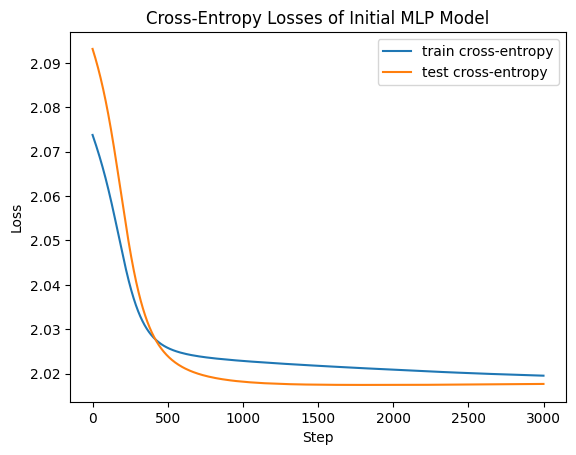

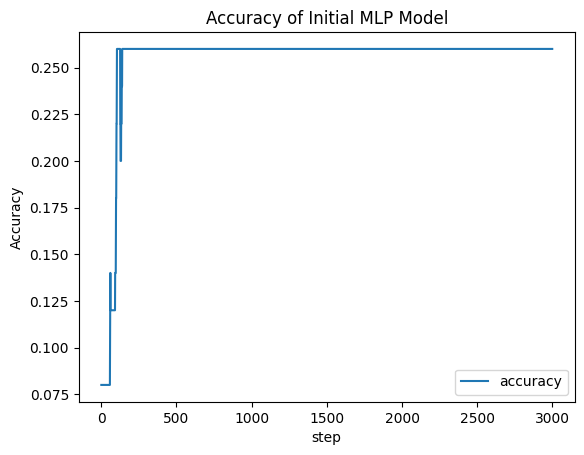

final MLP accuracy: 0.25999999046325684
final MLP training loss: 2.019521474838257


In [92]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.linear_1 = nn.Linear(input_size, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.linear_1(x)
        out = F.sigmoid(out)
        out = self.linear_2(out)
        out = F.softmax(out, dim = 1)
        return out

model = MLP(input_dim, 50, output_dim)

n_epochs_mlp = 3000
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
train_losses_mlp = np.zeros((n_epochs_mlp,))
test_losses_mlp = np.zeros((n_epochs_mlp,))
accuracies_mlp = np.zeros((n_epochs_mlp,))

for epoch in range(n_epochs_mlp):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    train_losses_mlp[epoch] = loss.item()

    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses_mlp[epoch] = test_loss.item()
        accuracies_mlp[epoch] = (torch.sum(test_outputs.argmax(dim=1) == y_test) / y_test.shape[0]).item()
    loss.backward()
    optimizer.step()

plt.figure(1)
plt.plot(range(n_epochs_mlp), train_losses_mlp, label='train cross-entropy')
plt.plot(range(n_epochs_mlp), test_losses_mlp, label='test cross-entropy')
plt.title("Cross-Entropy Losses of Initial MLP Model")

plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(2)
plt.plot(range(n_epochs_mlp), accuracies_mlp, label='accuracy')

plt.title("Accuracy of Initial MLP Model")
plt.xlabel('step')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(f"final MLP accuracy: {accuracies_mlp[-1]}")
print(f"final MLP training loss: {train_losses_mlp[-1]}")

From the graphs, we can see that we're underfitting the model, so we need to make the model more complex by adding more hidden units.

### Iterating Number of Hidden Units

Hidden Layers: 50
final MLP accuracy: 0.25999999046325684
final MLP training loss: 2.0212390422821045
final MLP testing loss: 2.0163984298706055

Hidden Layers: 60
final MLP accuracy: 0.25999999046325684
final MLP training loss: 2.0217392444610596
final MLP testing loss: 2.0106797218322754

Hidden Layers: 70
final MLP accuracy: 0.25999999046325684
final MLP training loss: 2.0192975997924805
final MLP testing loss: 2.0160858631134033

Hidden Layers: 80
final MLP accuracy: 0.25999999046325684
final MLP training loss: 2.0182271003723145
final MLP testing loss: 2.0147945880889893

Hidden Layers: 90
final MLP accuracy: 0.25999999046325684
final MLP training loss: 2.018242359161377
final MLP testing loss: 2.0149986743927

Hidden Layers: 100
final MLP accuracy: 0.25999999046325684
final MLP training loss: 2.019832134246826
final MLP testing loss: 2.0164496898651123



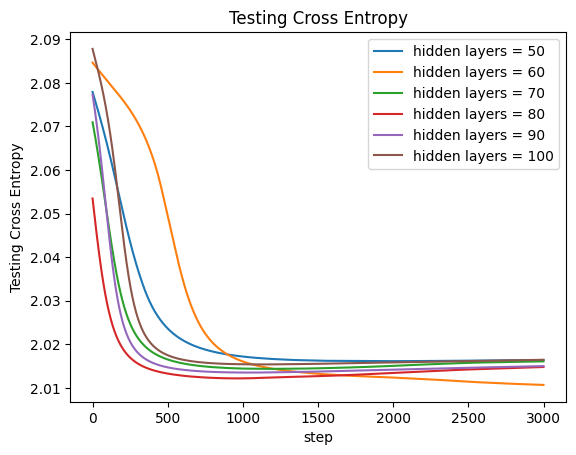

In [95]:
hidden_layers = 50


while hidden_layers <= 100:
    model = MLP(input_dim, hidden_layers, output_dim)
    print(f"Hidden Layers: {hidden_layers}")
    n_epochs_mlp = 3000
    learning_rate = 0.01
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    train_losses_mlp = np.zeros((n_epochs_mlp,))
    test_losses_mlp = np.zeros((n_epochs_mlp,))
    accuracies_mlp = np.zeros((n_epochs_mlp,))

    for epoch in range(n_epochs_mlp):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        train_losses_mlp[epoch] = loss.item()

        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_losses_mlp[epoch] = test_loss.item()
            accuracies_mlp[epoch] = (torch.sum(test_outputs.argmax(dim=1) == y_test) / y_test.shape[0]).item()
        loss.backward()
        optimizer.step()

    plt.plot(range(n_epochs_mlp), test_losses_mlp, label=f'hidden layers = {hidden_layers}')

    plt.xlabel('step')
    plt.ylabel("Testing Cross Entropy")
    plt.title("Testing Cross Entropy")
    plt.legend()

    print(f"final MLP accuracy: {accuracies_mlp[-1]}")
    print(f"final MLP training loss: {train_losses_mlp[-1]}")
    print(f"final MLP testing loss: {test_losses_mlp[-1]}")
    print("")
    hidden_layers += 10

From the iteration, it seems that our model minimizes when the number of hidden layers is between 60 and 90. Now that we have a range to look at, we can once again iterate the number of hidden layers, with our range being between 60 and 80 layers.

Hidden Layers: 60
final MLP accuracy: 0.25999999046325684
final MLP training loss: 2.0190789699554443
final MLP testing loss: 2.0162229537963867

Hidden Layers: 65
final MLP accuracy: 0.25999999046325684
final MLP training loss: 2.018707513809204
final MLP testing loss: 2.0184662342071533

Hidden Layers: 70
final MLP accuracy: 0.25999999046325684
final MLP training loss: 2.019070625305176
final MLP testing loss: 2.014129877090454

Hidden Layers: 75
final MLP accuracy: 0.25999999046325684
final MLP training loss: 2.0190446376800537
final MLP testing loss: 2.017590284347534

Hidden Layers: 80
final MLP accuracy: 0.25999999046325684
final MLP training loss: 2.0184924602508545
final MLP testing loss: 2.0167794227600098



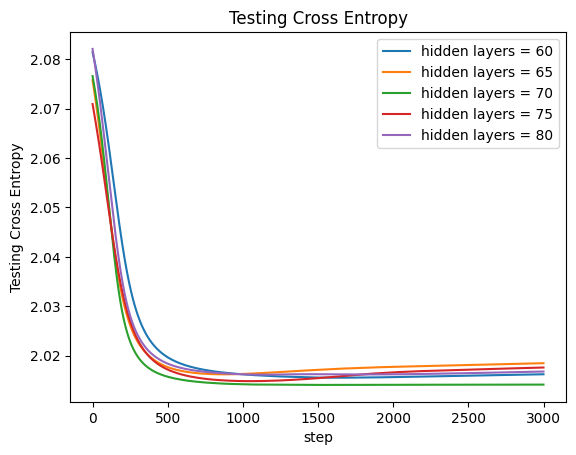

In [96]:
hidden_layers = 60


while hidden_layers <= 80:
    model = MLP(input_dim, hidden_layers, output_dim)
    print(f"Hidden Layers: {hidden_layers}")
    n_epochs_mlp = 3000
    learning_rate = 0.01
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    train_losses_mlp = np.zeros((n_epochs_mlp,))
    test_losses_mlp = np.zeros((n_epochs_mlp,))
    accuracies_mlp = np.zeros((n_epochs_mlp,))

    for epoch in range(n_epochs_mlp):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        train_losses_mlp[epoch] = loss.item()

        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_losses_mlp[epoch] = test_loss.item()
            accuracies_mlp[epoch] = (torch.sum(test_outputs.argmax(dim=1) == y_test) / y_test.shape[0]).item()
        loss.backward()
        optimizer.step()

    plt.plot(range(n_epochs_mlp), test_losses_mlp, label=f'hidden layers = {hidden_layers}')

    plt.xlabel('step')
    plt.ylabel("Testing Cross Entropy")
    plt.title("Testing Cross Entropy")
    plt.legend()

    print(f"final MLP accuracy: {accuracies_mlp[-1]}")
    print(f"final MLP training loss: {train_losses_mlp[-1]}")
    print(f"final MLP testing loss: {test_losses_mlp[-1]}")
    print("")
    hidden_layers += 5

From this, we can see that the optimal number of hidden layers is 70, but now we need to check and see how it compares the the training data loss and what the accuracy of the model is.

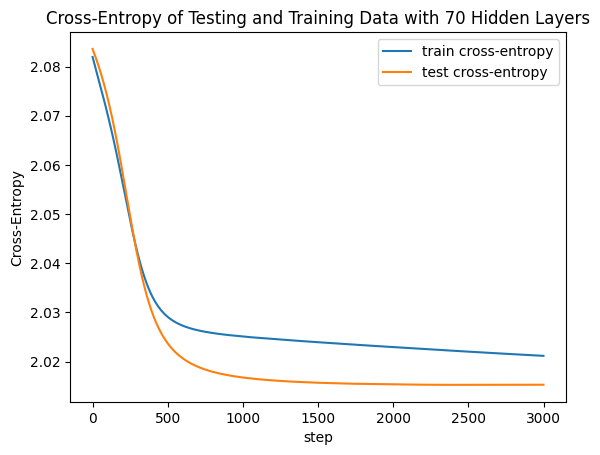

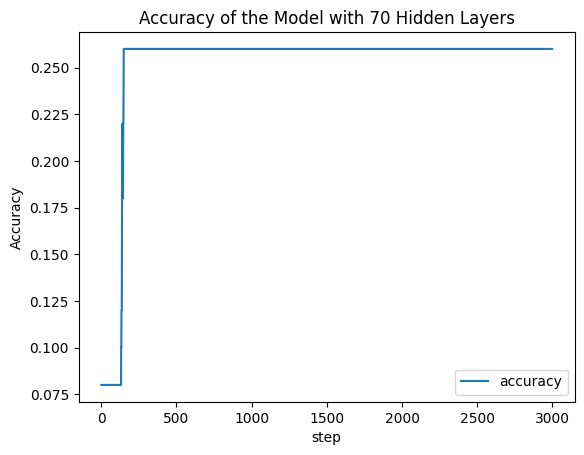

final MLP accuracy: 0.25999999046325684
final MLP training loss: 2.0211682319641113


In [123]:
model = MLP(input_dim, 70, output_dim)

n_epochs_mlp = 3000
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
train_losses_mlp = np.zeros((n_epochs_mlp,))
test_losses_mlp = np.zeros((n_epochs_mlp,))
accuracies_mlp = np.zeros((n_epochs_mlp,))

for epoch in range(n_epochs_mlp):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    train_losses_mlp[epoch] = loss.item()

    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses_mlp[epoch] = test_loss.item()
        accuracies_mlp[epoch] = (torch.sum(test_outputs.argmax(dim=1) == y_test) / y_test.shape[0]).item()
    loss.backward()
    optimizer.step()

plt.figure()
plt.plot(range(n_epochs_mlp), train_losses_mlp, label='train cross-entropy')
plt.plot(range(n_epochs_mlp), test_losses_mlp, label='test cross-entropy')

plt.xlabel('step')
plt.ylabel("Cross-Entropy")
plt.title("Cross-Entropy of Testing and Training Data with 70 Hidden Layers")
plt.legend()
plt.show()

plt.figure()
plt.plot(range(n_epochs_mlp), accuracies_mlp, label='accuracy')

plt.xlabel('step')
plt.ylabel("Accuracy")
plt.title("Accuracy of the Model with 70 Hidden Layers")
plt.legend()
plt.show()

print(f"final MLP accuracy: {accuracies_mlp[-1]}")
print(f"final MLP training loss: {train_losses_mlp[-1]}")

### Iterating Learning Rate

We've found a good number of hidden layers, but our model is still underfitting. We can increase complexity by decreasing the learning rate of the model to `0.001`. 

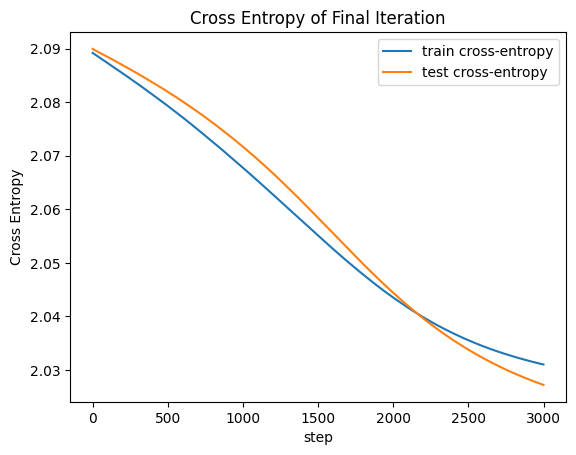

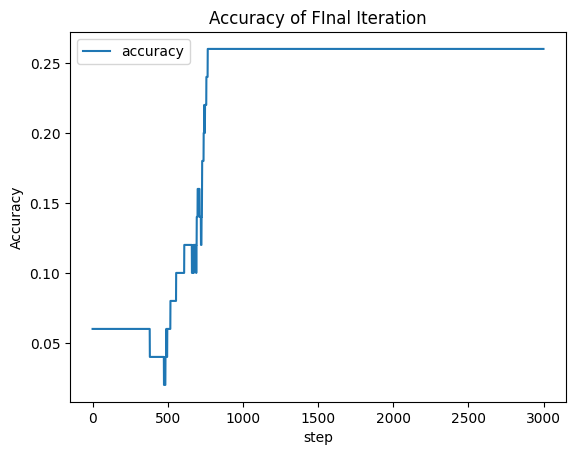

final MLP accuracy: 0.25999999046325684
final MLP training loss: 2.0310213565826416


In [126]:
model = MLP(input_dim, 70, output_dim)

n_epochs_mlp = 3000
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
train_losses_mlp = np.zeros((n_epochs_mlp,))
test_losses_mlp = np.zeros((n_epochs_mlp,))
accuracies_mlp = np.zeros((n_epochs_mlp,))

for epoch in range(n_epochs_mlp):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    train_losses_mlp[epoch] = loss.item()

    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses_mlp[epoch] = test_loss.item()
        accuracies_mlp[epoch] = (torch.sum(test_outputs.argmax(dim=1) == y_test) / y_test.shape[0]).item()
    loss.backward()
    optimizer.step()

plt.figure()
plt.plot(range(n_epochs_mlp), train_losses_mlp, label='train cross-entropy')
plt.plot(range(n_epochs_mlp), test_losses_mlp, label='test cross-entropy')

plt.xlabel('step')
plt.ylabel("Cross Entropy")
plt.title("Cross Entropy of Final Iteration")
plt.legend()
plt.show()

plt.figure()
plt.plot(range(n_epochs_mlp), accuracies_mlp, label='accuracy')

plt.xlabel('step')
plt.ylabel("Accuracy")
plt.title("Accuracy of FInal Iteration")
plt.legend()
plt.show()

print(f"final MLP accuracy: {accuracies_mlp[-1]}")
print(f"final MLP training loss: {train_losses_mlp[-1]}")

The accuracy of this model isn't great, but the learning rate is better! There are a couple of reasons why the accuracy isn't very good. The first is that the model may not be complex enough and doesn't have enough layers. However, the other reason, which I think is more compelling, is that the data simply doesn't have a pattern that the model can learn from. Grades are dependent on factors that aren't reflected in this data set, such as class participation, test scores, and a teacher's perception of you. While factors such as transportation, age, and gender may affect your grades slightly, they aren't big determinators in what your final grade is. 

## Conclusion

This algorithm could be tested by piloting it at a school and comparing the predicted grades to the actual grades students recieve. However, in order for this algorithm to be piloted, the accuarcy needs to improve significantly. More training data may be able to improve accuarcy, assuming there is a pattern that the machine can learn from. However, if it turns out there is not pattern, then the accuarcy will not improve, no matter how much data you train the model with. 

Overall, I'd classify this model as bad. The data isn't great to learn from, meaning the accuracy is poor and the learning loss is high. Additionally, this model may be oversimplified for the complexity of predicting student grades, as academic performance can depend on a wide variety of factors not captured in the current dataset. Incorporating more features could potentially help the model learn better patterns.

Moreover, the ethical implications of using an algorithm like this in a school setting should not be overlooked. Stakeholders such as students, teachers, and administrators would need to be carefully considered. If the model were implemented with poor accuracy, it could unfairly label students or create biases in decision-making around grades. This could lead to unintended consequences like unjust academic tracking or harming students' self-esteem and future opportunities.

The risks of deploying a flawed model include undermining trust in data-driven decision-making and potentially disadvantaging certain groups of students. These risks could be mitigated by ensuring transparency in how predictions are made, involving human oversight in any automated grading suggestions, and continuously monitoring the model’s performance to identify and rectify biases. Without significant improvements, this algorithm in its current form would not create value and could even cause harm in educational contexts.